# Se importan las librerias

In [5]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
import nltk
from gensim.models import Word2Vec

# Se descarga el recurso 'punkt' para tokenizar o separar palabras
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Se importa el archivo "meta_google_miami.parquet" que está asociado a 800 restaurantes de Miami filtrados

In [6]:
meta=pd.read_csv("Metadata.csv")

# Se importa el archivo "data_filtrada.parquet" que posee un gran conjunto de palabras útiles para entrenar el modelo

In [7]:
meta_1=pd.read_parquet("data_filtrada.parquet")

# Se guardan las categorías únicas

In [8]:
categorias_existentes = meta_1['category'].unique()

# Se utiliza el algoritmo KernelDensity que busca la densidad en la coordenadas de los restaurantes

In [9]:
# Se obtienen las coordenadas de todos los restaurantes
coordenadas = meta[['latitude', 'longitude']].values

# Se inicializa el modelo de Kernel Density Estimation (KDE)
kde = KernelDensity(bandwidth=0.01, metric='haversine')

# Se ajusta el modelo a las coordenadas de los restaurantes
kde.fit(np.radians(coordenadas))

# Se calcula las densidades para todas las coordenadas de los restaurantes
densidades = kde.score_samples(np.radians(coordenadas))

# Se agregan la columna de densidad al DataFrame "meta"
meta['densidad'] = densidades


# Se muestran las categorías del dataset

In [10]:
categorias_existentes

array(['Korean restaurant', 'Restaurant',
       'Bakery, Health food restaurant', ...,
       'Bar & grill, Convenience store, Lottery retailer, Pizza delivery, Propane supplier, Sandwich shop',
       'Brazilian restaurant, Bistro, Brazilian pastelaria, Diner, Fast food restaurant, Pub, Restaurant',
       'Mexican restaurant, Bar, Pub, Restaurant'], dtype=object)

#Se cambia el formato de la columna "avg_rating" a numérico

In [11]:
meta['avg_rating'] = pd.to_numeric(meta['avg_rating'], errors='coerce')


# Se entrena un modelo de búsqueda de palabras similares llamado Word2Vec

In [12]:
# Se limpia las comas y espacios en blanco en las categorías antes de tokenizar
categorias_limpio = [re.sub(r'[^\w\s]', '', category) for category in categorias_existentes]
categorias_tokenizadas = [word_tokenize(category) for category in categorias_limpio]

# Se entrena el modelo Word2Vec en las categorías tokenizadas
model = Word2Vec(categorias_tokenizadas, vector_size=300, window=5, min_count=5, sg=0)

# Se guarda el modelo entrenado con el dataset

In [13]:
model.save("modelo_word2vec.bin")

# Se prueba el algoritmo entrenado

In [14]:
# Se obtiene la palabra ingresada por el usuario
palabra = input("Ingresa una palabra: ")

# Se limpia la palabra ingresada por el usuario
palabra = re.sub(r'[^\w\s]', '', palabra)

# Se entrena la palabra más cercana según la similitud del coseno
try:
    palabra_similar, similaridad = model.wv.most_similar(palabra, topn=1)[0]
    print(f"La palabra más cercana a '{palabra}' es '{palabra_similar}' con una similitud de coseno de {similaridad:.2f}")

    # Se filtra las categorías que contienen la palabra similar
    categorias_con_palabra = [categoria for categoria in categorias_existentes if palabra_similar in categoria]
    categorias_sin_palabra = [categoria for categoria in categorias_existentes if palabra_similar not in categoria]

    # Se combina las dos listas de categorías, poniendo las categorías con la palabra al principio
    categorias_filtradas = categorias_con_palabra + categorias_sin_palabra

    # Se filtra el DataFrame 'meta' por las categorías encontradas

    meta_filtro = meta[meta['category'].isin(categorias_filtradas)]

except KeyError:
    print(f"'{palabra}' no se ha logrado encontrar alguna asociación con la palabra ingresada.")


Ingresa una palabra: Mexican
La palabra más cercana a 'Mexican' es 'Taco' con una similitud de coseno de 0.83


## Se utiliza el algoritmo entrenado para mostrar los restaurantes más recomendados, utilizando la optimización de una suma ponderada, que vincula las características "densidad" "puntaje" y "número de reviews" con el metodo del descenso del gradiente

# Función a optimizar:

### puntuación restaurante = peso_puntaje * puntaje_normalizado + peso_densidad * densidad_normalizada + peso_nºreviews * nº_reviews_normalizado

In [15]:
# Pesos en el rango [0, 1]
initial_weights = [0.25, 0.25, 0.25]  # Valores iniciales de los pesos

# Se normalizan las columnas de puntuación, densidad y número de revisiones entre 0 y 1
scaler = MinMaxScaler()
meta_filtro['puntaje_normalizado'] = scaler.fit_transform(meta_filtro[['avg_rating']])
meta_filtro['densidad_normalizada'] = scaler.fit_transform(meta_filtro[['densidad']])
meta_filtro['num_of_reviews_normalizado'] = scaler.fit_transform(meta_filtro[['num_of_reviews']])

# Se define la función objetivo para minimizar
def objective_function(weights):
    puntuacion_restaurante = (
        weights[0] * meta_filtro['densidad_normalizada'] +
        weights[1] * meta_filtro['puntaje_normalizado'] +
        weights[2] * meta_filtro['num_of_reviews_normalizado']
    )
    return -puntuacion_restaurante.sum()

# Devuelve la suma negativa de la puntuación total que es equivalente que es equivalente a haber buscado el máximo

# Se definen las restricciones de los pesos (en este caso, todos estánr entre 0 y 1)
constraints = [{'type': 'ineq', 'fun': lambda w: w[i]} for i in range(len(initial_weights))]

# Se optimizan los pesos usando el algoritmo de Descenso del Gradiente
result = minimize(objective_function, initial_weights, constraints=constraints)

# Se obtienen los pesos optimizados
optimized_weights = result.x

# Se calcula la puntuacion_restaurante con los pesos optimizados
meta_filtro['puntuacion_restaurante'] = (
    optimized_weights[0] * meta_filtro['densidad_normalizada'] +
    optimized_weights[1] * meta_filtro['puntaje_normalizado'] +
    optimized_weights[2] * meta_filtro['num_of_reviews_normalizado']
)

# Ordena el DataFrame en función de la puntuación restaurante en orden decreciente
meta_ordenado = meta_filtro.sort_values(by='puntuacion_restaurante', ascending=False)

In [18]:
meta_ordenado[["local_name","category"]].head(15)

,local_name,category
671,La Diosa taqueria,Restaurant
229,OCEAN CAFE,Restaurant
57,Homyn Food Truck,Restaurant
508,El King Taqueria Food Truck,Mexican restaurant
191,Eurobuilding Miami,Restaurant
185,Riguth Gourmet,Restaurant
14,Thea's,Restaurant
15,Jerico Food Service Equipment and Supply,Restaurant
268,Signatures7,Restaurant
105,La Cocotte,Restaurant


# Se muestra el orden de importancia para cada característica

In [21]:
# Nombres de las características correspondientes
nombres = ['densidad', 'puntaje_normalizado', 'num_of_reviews']

# Crea un diccionario que asocie las características con sus pesos optimizados
dic = {nombres[i]: optimized_weights[i] for i in range(len(nombres))}

# Imprime el diccionario para ver el orden de importancia
print(dic)

{'densidad': 3.0068058120711683e+37, 'puntaje_normalizado': 2.4833399272251277e+37, 'num_of_reviews': 6.436618418159377e+35}


# Es importante observar como el orden de iportancia de las características varía de acuerdo a la elección de palabra hecha por el usuario

# Se corrobora la independencia de las características utilizadas. Esto es importante para descartar características que puedan estar de más y sesgar el modelo

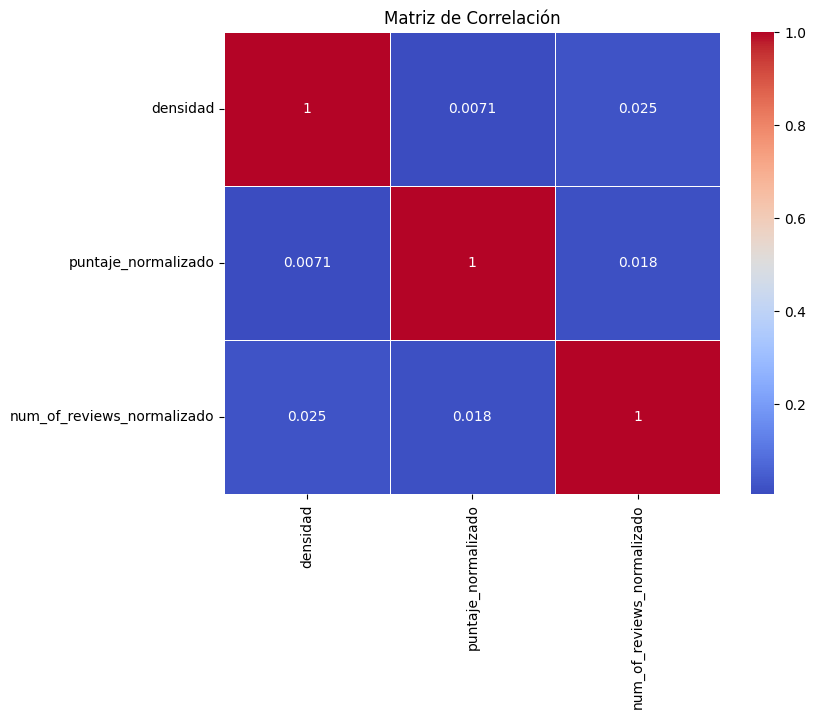

In [22]:
# Se calcula la matriz de correlación
corr = meta_filtro[['densidad', 'puntaje_normalizado', 'num_of_reviews_normalizado']].corr()

# Se crea un mapa de calor (heatmap) para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Se observa la correlación entre la puntuación de los restaurantes filtrados y cada característica usada

In [23]:
# Calcula las correlaciones entre "puntuacion_restaurante" y las tres columnas normalizadas
correlation_puntaje = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['puntaje_normalizado'])
correlation_densidad = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['densidad_normalizada'])
correlation_reviews = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['num_of_reviews_normalizado'])

print(f"Correlación entre Puntuación del Restaurante y Puntaje Normalizado: {correlation_puntaje}")
print(f"Correlación entre Puntuación del Restaurante y Densidad Normalizada: {correlation_densidad}")
print(f"Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: {correlation_reviews}")


Correlación entre Puntuación del Restaurante y Puntaje Normalizado: 0.6304929952944648
Correlación entre Puntuación del Restaurante y Densidad Normalizada: 0.7806115107684638
Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: 0.037307349491802214
